# Import libraries

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import LabelEncoder, label_binarize
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import torch.optim as optim
import torchvision.models as models
import time
import copy
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, f1_score, roc_auc_score
import seaborn as sns
from itertools import cycle
from collections import Counter

# Set Seeds for Reproducibility

In [2]:
import random

# Set seeds for reproducibility
SEED = 42

# Python random
random.seed(SEED)

# Numpy
np.random.seed(SEED)

# PyTorch
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)  # if using multi-GPU

# PyTorch backend
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

print(f"Seeds set to {SEED} for reproducibility")

Seeds set to 42 for reproducibility


# Data Transformation

In [3]:
# ImageNet normalization constants
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

# Training transformations with data augmentation
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(
        size=224,
        scale=(0.9, 1.0),
        ratio=(0.95, 1.05)
    ),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.ColorJitter(
        brightness=0.1,
        contrast=0.1,
        saturation=0.05,
        hue=0.02
    ),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=IMAGENET_MEAN,
        std=IMAGENET_STD
    )
])

# Validation and test transformations without augmentation
val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=IMAGENET_MEAN,
        std=IMAGENET_STD
    )
])

# Dataset

In [4]:
BATCH_SIZE = 16
NUM_WORKERS = 4

class BladderTissueDataset(Dataset):
    def __init__(self, dataframe, transform=None, label_encoder=None, fit_label_encoder=False):
        """
        Args:
            dataframe (DataFrame): DataFrame with HLY (image paths) and tissue type (labels) columns.
            transform (callable, optional): Optional transform to be applied on a sample.
            label_encoder (LabelEncoder, optional): Pre-fitted label encoder. If None, creates new one.
            fit_label_encoder (bool): Whether to fit the label encoder on this dataset's labels.
        """
        self.data = dataframe.reset_index(drop=True)
        self.transform = transform
        
        if label_encoder is None:
            self.label_encoder = LabelEncoder()
            if fit_label_encoder:
                self.labels = self.label_encoder.fit_transform(self.data['tissue type'])
            else:
                raise ValueError("Must provide label_encoder or set fit_label_encoder=True")
        else:
            self.label_encoder = label_encoder
            self.labels = self.label_encoder.transform(self.data['tissue type'])
        
        self.image_paths = self.data['HLY'].tolist()
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        # Load image
        img_path = self.image_paths[idx]
        try:
            image = Image.open(img_path).convert('RGB')
        except Exception as e:
            print(f"Error loading image: {img_path}")
            image = Image.new('RGB', (224, 224), color='black')
        
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, torch.tensor(label, dtype=torch.long)
    
    def get_label_encoder(self):
        """Return the label encoder for use with other datasets"""
        return self.label_encoder
    
    def get_class_names(self):
        """Return the original class names"""
        return self.label_encoder.classes_

In [5]:
# Create datasets from DataFrames
def create_datasets_from_dataframes(train_df, val_df, test_df):
    """
    Create train, validation, and test datasets with proper label encoding
    """
    # Create training dataset and fit label encoder
    train_dataset = BladderTissueDataset(
        dataframe=train_df, 
        transform=train_transform,
        fit_label_encoder=True
    )
    
    # Get the fitted label encoder
    le = train_dataset.get_label_encoder()
    
    # Create validation dataset using the same label encoder
    val_dataset = BladderTissueDataset(
        dataframe=val_df,
        transform=val_test_transform,
        label_encoder=le
    )
    
    # Create test dataset using the same label encoder
    test_dataset = BladderTissueDataset(
        dataframe=test_df,
        transform=val_test_transform,
        label_encoder=le
    )
    
    return train_dataset, val_dataset, test_dataset, le

# Dataloader

In [6]:
# Create dataloaders
def create_dataloaders(train_dataset, val_dataset, test_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS):
    """
    Create dataloaders for training, validation, and testing
    """
    # Worker seed for reproducibility
    def seed_worker(worker_id):
        worker_seed = torch.initial_seed() % 2**32
        np.random.seed(worker_seed)
        random.seed(worker_seed)
    
    g = torch.Generator()
    g.manual_seed(42)
    
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True,
        drop_last=True,
        worker_init_fn=seed_worker,
        generator=g
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True,
        worker_init_fn=seed_worker,    
        generator=g    
    )

    test_loader = DataLoader(
        test_dataset,
        pin_memory=True,
        batch_size=batch_size,
        num_workers=num_workers,
        shuffle=False,
        worker_init_fn=seed_worker,
        generator=g
    )
    return train_loader, val_loader, test_loader

In [7]:
train_df = pd.read_csv("/kaggle/input/ebt-dataset/train.csv")
test_df = pd.read_csv("/kaggle/input/ebt-dataset/test.csv")
valid_df = pd.read_csv("/kaggle/input/ebt-dataset/valid.csv")

In [8]:
# Analyze imaging type distribution across datasets and tissue types
print("=" * 60)
print("IMAGING TYPE ANALYSIS")
print("=" * 60)

for df_name, df in [("Train", train_df), ("Validation", valid_df), ("Test", test_df)]:
    print(f"\n{df_name} Set:")
    print(f"  Total samples: {len(df)}")
    print(f"\n  Imaging Type Distribution:")
    print(df['imaging type'].value_counts())
    print(f"\n  Imaging Type by Tissue Type:")
    print(df.groupby(['tissue type', 'imaging type']).size().unstack(fill_value=0))
    print("-" * 60)

IMAGING TYPE ANALYSIS

Train Set:
  Total samples: 1224

  Imaging Type Distribution:
imaging type
WLI    996
NBI    228
Name: count, dtype: int64

  Imaging Type by Tissue Type:
imaging type  NBI  WLI
tissue type           
HGC            45  264
LGC            97  385
NST            58  288
NTL            28   59
------------------------------------------------------------

Validation Set:
  Total samples: 304

  Imaging Type Distribution:
imaging type
WLI    250
NBI     54
Name: count, dtype: int64

  Imaging Type by Tissue Type:
imaging type  NBI  WLI
tissue type           
HGC             7   79
LGC            21   91
NST            17   67
NTL             9   13
------------------------------------------------------------

Test Set:
  Total samples: 189

  Imaging Type Distribution:
imaging type
WLI    150
NBI     39
Name: count, dtype: int64

  Imaging Type by Tissue Type:
imaging type  NBI  WLI
tissue type           
HGC            12   62
LGC            27   26
NST            

# Analyze Imaging Type Distribution

In [9]:
train_dataset, val_dataset, test_dataset, label_encoder = create_datasets_from_dataframes(
    train_df, valid_df, test_df
)

train_loader, val_loader, test_loader = create_dataloaders(
    train_dataset, val_dataset, test_dataset, 
    batch_size=32, 
    num_workers=4
)

# Print encoding information
print(f"Tissue Types: {label_encoder.classes_}")

Tissue Types: ['HGC' 'LGC' 'NST' 'NTL']


# Utility Functions

In [10]:
def compute_class_weights(train_loader, num_classes):
    """Compute class weights for handling imbalanced datasets"""
    class_counts = Counter()

    for _, labels in train_loader:
        class_counts.update(labels.numpy())

    total_samples = sum(class_counts.values())

    weights = []
    for i in range(num_classes):
        weights.append(total_samples / (num_classes * class_counts[i]))

    return torch.tensor(weights, dtype=torch.float)

# Model Training Framework

In [11]:
class ModelTrainer:
    def __init__(self, model, train_loader, val_loader, test_loader, device='cuda'):
        self.model = model.to(device)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.test_loader = test_loader
        self.device = device
        
        # Training history
        self.train_losses = []
        self.val_losses = []
        self.train_accuracies = []
        self.val_accuracies = []
        
    def train_model(self, num_epochs=25, lr=0.001, weight_decay=1e-4, save_best=True, model_name="model"):
        """Train the model with early stopping and best model saving based on macro-F1"""
        
        # Loss function and optimizer
        class_weights = compute_class_weights(self.train_loader, num_classes=len(self.train_loader.dataset.get_label_encoder().classes_))
        class_weights = class_weights.to(self.device)
        criterion = nn.CrossEntropyLoss(weight=class_weights)
        optimizer = optim.Adam(self.model.parameters(), lr=lr, weight_decay=weight_decay)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
        
        # Best model tracking
        best_val_f1 = 0.0
        best_model_wts = copy.deepcopy(self.model.state_dict())
        patience = 5
        patience_counter = 0
        
        print(f"Starting training for {num_epochs} epochs...")
        print("-" * 60)
        
        start_time = time.time()
        
        for epoch in range(num_epochs):
            print(f'Epoch {epoch+1}/{num_epochs}')
            print('-' * 10)
            
            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    self.model.train()
                    dataloader = self.train_loader
                else:
                    self.model.eval()
                    dataloader = self.val_loader
                
                running_loss = 0.0
                running_corrects = 0
                total_samples = 0
                all_preds = []
                all_labels = []
                
                # Progress bar
                pbar = tqdm(dataloader, desc=f'{phase.capitalize()} ')
                
                for inputs, labels in pbar:
                    inputs = inputs.to(self.device)
                    labels = labels.to(self.device)
                    
                    # Zero gradients
                    optimizer.zero_grad()
                    
                    # Forward pass
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = self.model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)
                        
                        # Backward pass (only in training)
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()
                    
                    # Statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                    total_samples += inputs.size(0)
                    
                    # Store predictions and labels for F1 calculation
                    all_preds.extend(preds.cpu().numpy())
                    all_labels.extend(labels.cpu().numpy())
                    
                    # Update progress bar
                    current_acc = running_corrects.double() / total_samples
                    pbar.set_postfix({
                        'Loss': f'{running_loss/total_samples:.4f}',
                        'Acc': f'{current_acc:.4f}'
                    })
                
                # Calculate epoch metrics
                epoch_loss = running_loss / total_samples
                epoch_acc = running_corrects.double() / total_samples
                epoch_f1 = f1_score(all_labels, all_preds, average='macro')
                
                print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} Macro-F1: {epoch_f1:.4f}')
                
                # Store metrics
                if phase == 'train':
                    self.train_losses.append(epoch_loss)
                    self.train_accuracies.append(epoch_acc.cpu())
                else:
                    self.val_losses.append(epoch_loss)
                    self.val_accuracies.append(epoch_acc.cpu())
                
                # Save best model based on validation macro-F1
                if phase == 'val' and epoch_f1 > best_val_f1:
                    best_val_f1 = epoch_f1
                    best_model_wts = copy.deepcopy(self.model.state_dict())
                    patience_counter = 0
                    if save_best:
                        torch.save(self.model.state_dict(), f'best_{model_name}.pth')
                        print(f'✓ New best model saved with validation macro-F1: {best_val_f1:.4f}')
                elif phase == 'val':
                    patience_counter += 1
            
            # Learning rate scheduler step (after both train and val phases)
            scheduler.step()
            
            # Early stopping
            if patience_counter >= patience:
                print(f'Early stopping triggered after {epoch+1} epochs')
                break
                
            print()
        
        # Training complete
        time_elapsed = time.time() - start_time
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best validation macro-F1: {best_val_f1:.4f}')
        
        # Load best model weights
        self.model.load_state_dict(best_model_wts)
        return self.model
    
    def evaluate_model(self, test_loader=None, class_names=['HGC', 'LGC', 'NST', 'NTL']):
        """Evaluate model on test set and return all metrics"""
        if test_loader is None:
            test_loader = self.test_loader
            
        self.model.eval()
        all_preds = []
        all_labels = []
        all_probs = []
        test_loss = 0.0
        correct = 0
        total = 0
        
        criterion = nn.CrossEntropyLoss()
        
        print("Evaluating on test set...")
        with torch.no_grad():
            for inputs, labels in tqdm(test_loader):
                inputs = inputs.to(self.device)
                labels = labels.to(self.device)
                
                outputs = self.model(inputs)
                probs = torch.softmax(outputs, dim=1)
                loss = criterion(outputs, labels)
                
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                test_loss += loss.item() * inputs.size(0)
                
                # Store for detailed metrics
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
                all_probs.extend(probs.cpu().numpy())
        
        # Calculate metrics
        test_acc = 100 * correct / total
        avg_test_loss = test_loss / total
        
        print(f'Test Accuracy: {test_acc:.2f}%')
        print(f'Test Loss: {avg_test_loss:.4f}')
        
        # Detailed classification report
        print("\nClassification Report:")
        report = classification_report(all_labels, all_preds, target_names=class_names, output_dict=True)
        print(classification_report(all_labels, all_preds, target_names=class_names))
        
        # Confusion Matrix
        cm = confusion_matrix(all_labels, all_preds)
        print(f"\nConfusion Matrix:")
        print(cm)
        
        # Compute ROC-AUC scores
        labels_bin = label_binarize(all_labels, classes=list(range(len(class_names))))
        probs_array = np.array(all_probs)
        
        # Per-class ROC-AUC
        per_class_auc = {}
        for i, class_name in enumerate(class_names):
            try:
                per_class_auc[class_name] = roc_auc_score(labels_bin[:, i], probs_array[:, i])
            except:
                per_class_auc[class_name] = 0.0
        
        # Macro ROC-AUC (average of per-class AUCs)
        macro_auc = np.mean(list(per_class_auc.values()))
        
        # Micro ROC-AUC (using all predictions)
        try:
            micro_auc = roc_auc_score(labels_bin.ravel(), probs_array.ravel())
        except:
            micro_auc = 0.0
        
        print(f"\nROC-AUC Scores:")
        print(f"Macro-average AUC: {macro_auc:.4f}")
        print(f"Micro-average AUC: {micro_auc:.4f}")
        for class_name, auc_score in per_class_auc.items():
            print(f"{class_name} AUC: {auc_score:.4f}")
        
        return {
            'accuracy': test_acc,
            'loss': avg_test_loss,
            'predictions': all_preds,
            'labels': all_labels,
            'probabilities': all_probs,
            'confusion_matrix': cm,
            'classification_report': report,
            'per_class_auc': per_class_auc,
            'macro_auc': macro_auc,
            'micro_auc': micro_auc
        }
    
    def plot_training_history(self, save_path=None):
        """Plot training and validation metrics"""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        
        # Plot losses
        ax1.plot(self.train_losses, label='Train Loss', marker='o')
        ax1.plot(self.val_losses, label='Validation Loss', marker='s')
        ax1.set_title('Model Loss')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.legend()
        ax1.grid(True)
        
        # Plot accuracies
        ax2.plot(self.train_accuracies, label='Train Accuracy', marker='o')
        ax2.plot(self.val_accuracies, label='Validation Accuracy', marker='s')
        ax2.set_title('Model Accuracy')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy')
        ax2.legend()
        ax2.grid(True)
        
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path)
        plt.show()

# Model Definitions

In [12]:
def create_regnet_y_400mf(num_classes=4, pretrained=True):
    """Create RegNet-Y-400MF model for bladder tissue classification"""
    model = models.regnet_y_400mf(weights='DEFAULT' if pretrained else None)
    num_features = model.fc.in_features
    model.fc = nn.Linear(num_features, num_classes)
    return model

def create_regnet_y_800mf(num_classes=4, pretrained=True):
    """Create RegNet-Y-800MF model for bladder tissue classification"""
    model = models.regnet_y_800mf(weights='DEFAULT' if pretrained else None)
    num_features = model.fc.in_features
    model.fc = nn.Linear(num_features, num_classes)
    return model

def create_regnet_y_1_6gf(num_classes=4, pretrained=True):
    """Create RegNet-Y-1.6GF model for bladder tissue classification"""
    model = models.regnet_y_1_6gf(weights='DEFAULT' if pretrained else None)
    num_features = model.fc.in_features
    model.fc = nn.Linear(num_features, num_classes)
    return model

# Configure GPU

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


# Visualization Functions

In [14]:
def plot_confusion_matrix(cm, class_names, model_name, save_path=None):
    """Plot confusion matrix with nice formatting"""
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names,
                cbar_kws={'label': 'Count'})
    plt.title(f'Confusion Matrix - {model_name}', fontsize=16, pad=20)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

def plot_roc_curves(labels, probs, class_names, model_name, save_path=None):
    """Plot ROC curves for multi-class classification"""
    # Binarize the labels
    n_classes = len(class_names)
    labels_bin = label_binarize(labels, classes=list(range(n_classes)))
    probs_array = np.array(probs)
    
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(labels_bin[:, i], probs_array[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(labels_bin.ravel(), probs_array.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    # Plot ROC curves
    plt.figure(figsize=(12, 8))
    colors = cycle(['blue', 'red', 'green', 'orange', 'purple'])
    
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'{class_names[i]} (AUC = {roc_auc[i]:.3f})')
    
    plt.plot(fpr["micro"], tpr["micro"], color='deeppink', linestyle=':', linewidth=3,
             label=f'Micro-average (AUC = {roc_auc["micro"]:.3f})')
    
    plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title(f'ROC Curves - {model_name}', fontsize=16, pad=20)
    plt.legend(loc="lower right", fontsize=10)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    
    return roc_auc

# Train and Evaluate Models

In [15]:
# Get class names from label encoder
class_names = list(label_encoder.classes_)
print(f"Classes: {class_names}")

# Store results for all models
all_results = []

Classes: ['HGC', 'LGC', 'NST', 'NTL']


## Train RegNet-Y-400MF

Training RegNet-Y-400MF
Downloading: "https://download.pytorch.org/models/regnet_y_400mf-e6988f5f.pth" to /root/.cache/torch/hub/checkpoints/regnet_y_400mf-e6988f5f.pth


100%|██████████| 16.8M/16.8M [00:00<00:00, 55.4MB/s]


Starting training for 25 epochs...
------------------------------------------------------------
Epoch 1/25
----------


Train : 100%|██████████| 38/38 [00:07<00:00,  4.83it/s, Loss=0.4966, Acc=0.8133]


Train Loss: 0.4966 Acc: 0.8133 Macro-F1: 0.7747


Val : 100%|██████████| 10/10 [00:01<00:00,  7.42it/s, Loss=0.6203, Acc=0.8158]


Val Loss: 0.6203 Acc: 0.8158 Macro-F1: 0.8057
✓ New best model saved with validation macro-F1: 0.8057

Epoch 2/25
----------


Train : 100%|██████████| 38/38 [00:06<00:00,  5.62it/s, Loss=0.1556, Acc=0.9457]


Train Loss: 0.1556 Acc: 0.9457 Macro-F1: 0.9319


Val : 100%|██████████| 10/10 [00:00<00:00, 10.12it/s, Loss=0.0635, Acc=0.9770]


Val Loss: 0.0635 Acc: 0.9770 Macro-F1: 0.9736
✓ New best model saved with validation macro-F1: 0.9736

Epoch 3/25
----------


Train : 100%|██████████| 38/38 [00:06<00:00,  5.49it/s, Loss=0.1252, Acc=0.9671]


Train Loss: 0.1252 Acc: 0.9671 Macro-F1: 0.9539


Val : 100%|██████████| 10/10 [00:01<00:00,  9.99it/s, Loss=0.0588, Acc=0.9737]


Val Loss: 0.0588 Acc: 0.9737 Macro-F1: 0.9666

Epoch 4/25
----------


Train : 100%|██████████| 38/38 [00:06<00:00,  5.59it/s, Loss=0.0974, Acc=0.9688]


Train Loss: 0.0974 Acc: 0.9688 Macro-F1: 0.9602


Val : 100%|██████████| 10/10 [00:01<00:00,  9.99it/s, Loss=0.1063, Acc=0.9539]


Val Loss: 0.1063 Acc: 0.9539 Macro-F1: 0.9637

Epoch 5/25
----------


Train : 100%|██████████| 38/38 [00:06<00:00,  5.62it/s, Loss=0.1321, Acc=0.9531]


Train Loss: 0.1321 Acc: 0.9531 Macro-F1: 0.9391


Val : 100%|██████████| 10/10 [00:00<00:00, 10.21it/s, Loss=0.2445, Acc=0.9079]


Val Loss: 0.2445 Acc: 0.9079 Macro-F1: 0.8829

Epoch 6/25
----------


Train : 100%|██████████| 38/38 [00:06<00:00,  5.57it/s, Loss=0.0802, Acc=0.9720]


Train Loss: 0.0802 Acc: 0.9720 Macro-F1: 0.9667


Val : 100%|██████████| 10/10 [00:00<00:00, 10.02it/s, Loss=0.0111, Acc=0.9967]


Val Loss: 0.0111 Acc: 0.9967 Macro-F1: 0.9974
✓ New best model saved with validation macro-F1: 0.9974

Epoch 7/25
----------


Train : 100%|██████████| 38/38 [00:06<00:00,  5.67it/s, Loss=0.0311, Acc=0.9877]


Train Loss: 0.0311 Acc: 0.9877 Macro-F1: 0.9876


Val : 100%|██████████| 10/10 [00:01<00:00,  9.99it/s, Loss=0.0567, Acc=0.9901]


Val Loss: 0.0567 Acc: 0.9901 Macro-F1: 0.9878

Epoch 8/25
----------


Train : 100%|██████████| 38/38 [00:06<00:00,  5.49it/s, Loss=0.0653, Acc=0.9778]


Train Loss: 0.0653 Acc: 0.9778 Macro-F1: 0.9798


Val : 100%|██████████| 10/10 [00:00<00:00, 10.16it/s, Loss=0.0195, Acc=0.9868]


Val Loss: 0.0195 Acc: 0.9868 Macro-F1: 0.9852

Epoch 9/25
----------


Train : 100%|██████████| 38/38 [00:06<00:00,  5.76it/s, Loss=0.0255, Acc=0.9918]


Train Loss: 0.0255 Acc: 0.9918 Macro-F1: 0.9865


Val : 100%|██████████| 10/10 [00:01<00:00,  8.95it/s, Loss=0.0208, Acc=0.9901]


Val Loss: 0.0208 Acc: 0.9901 Macro-F1: 0.9878

Epoch 10/25
----------


Train : 100%|██████████| 38/38 [00:06<00:00,  5.74it/s, Loss=0.0075, Acc=0.9984]


Train Loss: 0.0075 Acc: 0.9984 Macro-F1: 0.9987


Val : 100%|██████████| 10/10 [00:01<00:00,  9.66it/s, Loss=0.0215, Acc=0.9901]


Val Loss: 0.0215 Acc: 0.9901 Macro-F1: 0.9878

Epoch 11/25
----------


Train : 100%|██████████| 38/38 [00:06<00:00,  5.58it/s, Loss=0.0147, Acc=0.9951]


Train Loss: 0.0147 Acc: 0.9951 Macro-F1: 0.9935


Val : 100%|██████████| 10/10 [00:00<00:00, 10.00it/s, Loss=0.0200, Acc=0.9901]


Val Loss: 0.0200 Acc: 0.9901 Macro-F1: 0.9878
Early stopping triggered after 11 epochs
Training complete in 1m 27s
Best validation macro-F1: 0.9974


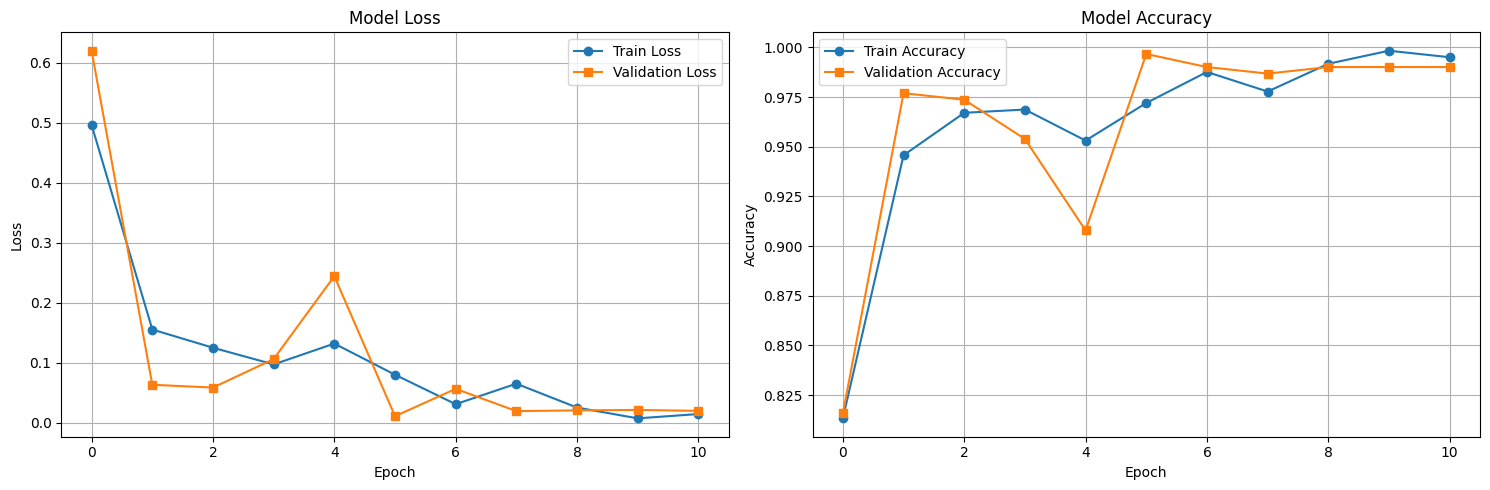

Evaluating on test set...


100%|██████████| 6/6 [00:01<00:00,  5.85it/s]


Test Accuracy: 50.79%
Test Loss: 1.5796

Classification Report:
              precision    recall  f1-score   support

         HGC       0.47      0.34      0.39        74
         LGC       0.58      0.42      0.48        53
         NST       0.65      0.89      0.75        37
         NTL       0.34      0.64      0.44        25

    accuracy                           0.51       189
   macro avg       0.51      0.57      0.52       189
weighted avg       0.52      0.51      0.50       189


Confusion Matrix:
[[25 16  7 26]
 [28 22  2  1]
 [ 0  0 33  4]
 [ 0  0  9 16]]

ROC-AUC Scores:
Macro-average AUC: 0.7995
Micro-average AUC: 0.7775
HGC AUC: 0.6709
LGC AUC: 0.7697
NST AUC: 0.9244
NTL AUC: 0.8329


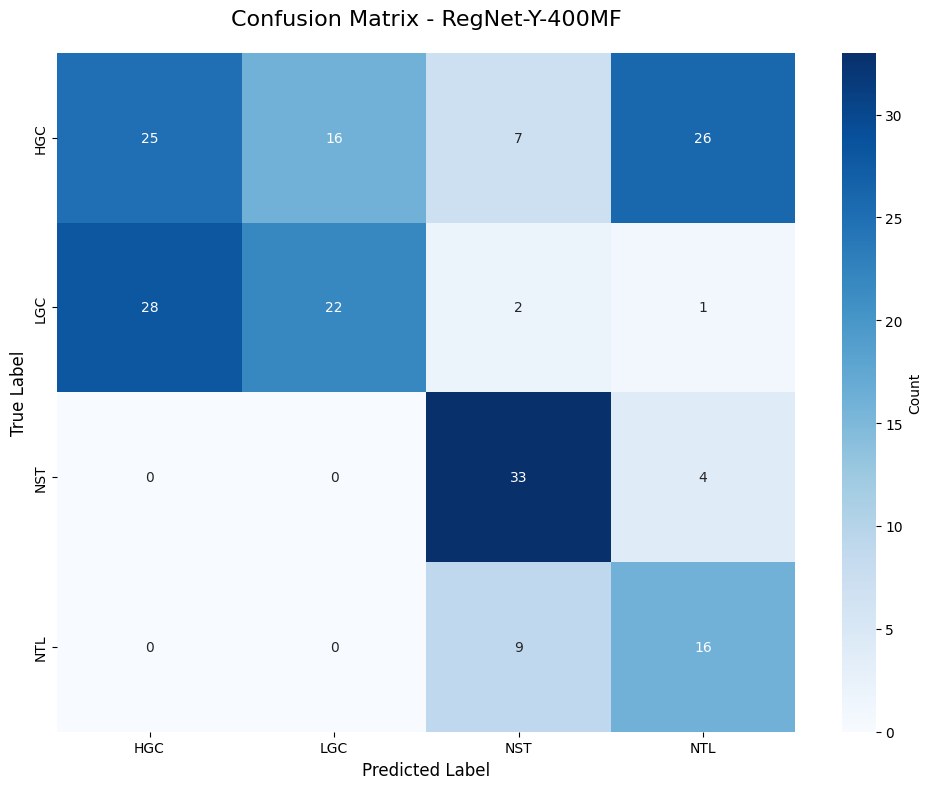

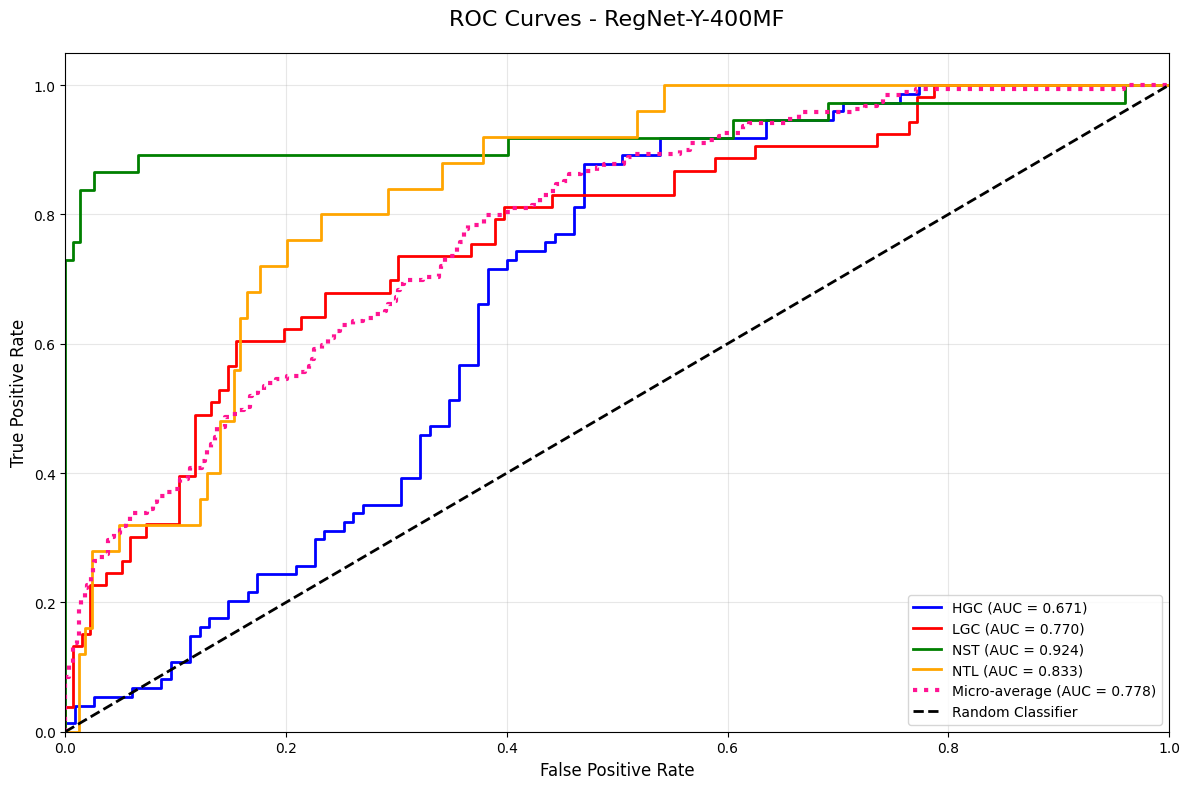


RegNet-Y-400MF training and evaluation complete!


In [16]:
print("=" * 80)
print("Training RegNet-Y-400MF")
print("=" * 80)

# Create RegNet-Y-400MF model
regnet_400mf = create_regnet_y_400mf(
    num_classes=4,
    pretrained=True
)

# Create trainer
trainer_400mf = ModelTrainer(regnet_400mf, train_loader, val_loader, test_loader, device=device)

# Train model
trained_model_400mf = trainer_400mf.train_model(num_epochs=25, lr=0.001, save_best=True, model_name="RegNet-Y-400MF")

# Plot training history
trainer_400mf.plot_training_history(save_path='regnet_y_400mf_training_history.png')

# Evaluate model
results_400mf = trainer_400mf.evaluate_model(class_names=class_names)

# Plot confusion matrix
plot_confusion_matrix(results_400mf['confusion_matrix'], class_names, 'RegNet-Y-400MF',
                      save_path='regnet_y_400mf_confusion_matrix.png')
# Plot ROC curves
roc_auc_400mf = plot_roc_curves(results_400mf['labels'], results_400mf['probabilities'], class_names, 'RegNet-Y-400MF',
                              save_path='regnet_y_400mf_roc_curves.png')
# Store results
results_400mf['model_name'] = 'RegNet-Y-400MF'
results_400mf['roc_auc'] = roc_auc_400mf
all_results.append(results_400mf)

print("\nRegNet-Y-400MF training and evaluation complete!")

## Train RegNet-Y-800MF

Training RegNet-Y-800MF
Downloading: "https://download.pytorch.org/models/regnet_y_800mf-58fc7688.pth" to /root/.cache/torch/hub/checkpoints/regnet_y_800mf-58fc7688.pth


100%|██████████| 24.8M/24.8M [00:00<00:00, 56.4MB/s]


Starting training for 25 epochs...
------------------------------------------------------------
Epoch 1/25
----------


Train : 100%|██████████| 38/38 [00:06<00:00,  5.62it/s, Loss=0.5011, Acc=0.8298]


Train Loss: 0.5011 Acc: 0.8298 Macro-F1: 0.7860


Val : 100%|██████████| 10/10 [00:01<00:00,  9.79it/s, Loss=0.5693, Acc=0.8553]


Val Loss: 0.5693 Acc: 0.8553 Macro-F1: 0.8200
✓ New best model saved with validation macro-F1: 0.8200

Epoch 2/25
----------


Train : 100%|██████████| 38/38 [00:06<00:00,  5.82it/s, Loss=0.2346, Acc=0.9309]


Train Loss: 0.2346 Acc: 0.9309 Macro-F1: 0.9179


Val : 100%|██████████| 10/10 [00:00<00:00, 10.41it/s, Loss=0.0575, Acc=0.9901]


Val Loss: 0.0575 Acc: 0.9901 Macro-F1: 0.9835
✓ New best model saved with validation macro-F1: 0.9835

Epoch 3/25
----------


Train : 100%|██████████| 38/38 [00:06<00:00,  5.92it/s, Loss=0.1487, Acc=0.9515]


Train Loss: 0.1487 Acc: 0.9515 Macro-F1: 0.9368


Val : 100%|██████████| 10/10 [00:00<00:00, 10.34it/s, Loss=1.2581, Acc=0.7336]


Val Loss: 1.2581 Acc: 0.7336 Macro-F1: 0.7093

Epoch 4/25
----------


Train : 100%|██████████| 38/38 [00:06<00:00,  5.72it/s, Loss=0.2292, Acc=0.9465]


Train Loss: 0.2292 Acc: 0.9465 Macro-F1: 0.9234


Val : 100%|██████████| 10/10 [00:00<00:00, 10.44it/s, Loss=0.2874, Acc=0.8980]


Val Loss: 0.2874 Acc: 0.8980 Macro-F1: 0.8539

Epoch 5/25
----------


Train : 100%|██████████| 38/38 [00:06<00:00,  5.76it/s, Loss=0.1012, Acc=0.9655]


Train Loss: 0.1012 Acc: 0.9655 Macro-F1: 0.9492


Val : 100%|██████████| 10/10 [00:01<00:00,  9.77it/s, Loss=0.0871, Acc=0.9638]


Val Loss: 0.0871 Acc: 0.9638 Macro-F1: 0.9407

Epoch 6/25
----------


Train : 100%|██████████| 38/38 [00:06<00:00,  5.77it/s, Loss=0.1756, Acc=0.9490]


Train Loss: 0.1756 Acc: 0.9490 Macro-F1: 0.9293


Val : 100%|██████████| 10/10 [00:00<00:00, 10.16it/s, Loss=0.0763, Acc=0.9770]


Val Loss: 0.0763 Acc: 0.9770 Macro-F1: 0.9772

Epoch 7/25
----------


Train : 100%|██████████| 38/38 [00:06<00:00,  5.92it/s, Loss=0.0537, Acc=0.9827]


Train Loss: 0.0537 Acc: 0.9827 Macro-F1: 0.9771


Val : 100%|██████████| 10/10 [00:00<00:00, 10.11it/s, Loss=0.0213, Acc=0.9967]


Val Loss: 0.0213 Acc: 0.9967 Macro-F1: 0.9933
✓ New best model saved with validation macro-F1: 0.9933

Epoch 8/25
----------


Train : 100%|██████████| 38/38 [00:06<00:00,  5.73it/s, Loss=0.0338, Acc=0.9885]


Train Loss: 0.0338 Acc: 0.9885 Macro-F1: 0.9882


Val : 100%|██████████| 10/10 [00:00<00:00, 10.15it/s, Loss=0.0121, Acc=0.9967]


Val Loss: 0.0121 Acc: 0.9967 Macro-F1: 0.9933

Epoch 9/25
----------


Train : 100%|██████████| 38/38 [00:06<00:00,  5.72it/s, Loss=0.0202, Acc=0.9910]


Train Loss: 0.0202 Acc: 0.9910 Macro-F1: 0.9898


Val : 100%|██████████| 10/10 [00:01<00:00,  9.87it/s, Loss=0.0075, Acc=0.9967]


Val Loss: 0.0075 Acc: 0.9967 Macro-F1: 0.9933

Epoch 10/25
----------


Train : 100%|██████████| 38/38 [00:06<00:00,  5.70it/s, Loss=0.0172, Acc=0.9942]


Train Loss: 0.0172 Acc: 0.9942 Macro-F1: 0.9942


Val : 100%|██████████| 10/10 [00:00<00:00, 10.06it/s, Loss=0.0080, Acc=0.9967]


Val Loss: 0.0080 Acc: 0.9967 Macro-F1: 0.9933

Epoch 11/25
----------


Train : 100%|██████████| 38/38 [00:06<00:00,  5.77it/s, Loss=0.0130, Acc=0.9967]


Train Loss: 0.0130 Acc: 0.9967 Macro-F1: 0.9961


Val : 100%|██████████| 10/10 [00:00<00:00, 10.13it/s, Loss=0.0063, Acc=1.0000]


Val Loss: 0.0063 Acc: 1.0000 Macro-F1: 1.0000
✓ New best model saved with validation macro-F1: 1.0000

Epoch 12/25
----------


Train : 100%|██████████| 38/38 [00:06<00:00,  5.73it/s, Loss=0.0156, Acc=0.9959]


Train Loss: 0.0156 Acc: 0.9959 Macro-F1: 0.9955


Val : 100%|██████████| 10/10 [00:01<00:00,  9.98it/s, Loss=0.0054, Acc=0.9967]


Val Loss: 0.0054 Acc: 0.9967 Macro-F1: 0.9933

Epoch 13/25
----------


Train : 100%|██████████| 38/38 [00:06<00:00,  5.70it/s, Loss=0.0075, Acc=0.9984]


Train Loss: 0.0075 Acc: 0.9984 Macro-F1: 0.9977


Val : 100%|██████████| 10/10 [00:01<00:00,  9.97it/s, Loss=0.0049, Acc=0.9967]


Val Loss: 0.0049 Acc: 0.9967 Macro-F1: 0.9933

Epoch 14/25
----------


Train : 100%|██████████| 38/38 [00:06<00:00,  5.73it/s, Loss=0.0104, Acc=0.9967]


Train Loss: 0.0104 Acc: 0.9967 Macro-F1: 0.9962


Val : 100%|██████████| 10/10 [00:00<00:00, 10.19it/s, Loss=0.0041, Acc=1.0000]


Val Loss: 0.0041 Acc: 1.0000 Macro-F1: 1.0000

Epoch 15/25
----------


Train : 100%|██████████| 38/38 [00:06<00:00,  5.89it/s, Loss=0.0099, Acc=0.9951]


Train Loss: 0.0099 Acc: 0.9951 Macro-F1: 0.9949


Val : 100%|██████████| 10/10 [00:01<00:00,  9.25it/s, Loss=0.0037, Acc=1.0000]


Val Loss: 0.0037 Acc: 1.0000 Macro-F1: 1.0000

Epoch 16/25
----------


Train : 100%|██████████| 38/38 [00:06<00:00,  5.85it/s, Loss=0.0162, Acc=0.9951]


Train Loss: 0.0162 Acc: 0.9951 Macro-F1: 0.9946


Val : 100%|██████████| 10/10 [00:01<00:00,  9.93it/s, Loss=0.0041, Acc=0.9967]


Val Loss: 0.0041 Acc: 0.9967 Macro-F1: 0.9933
Early stopping triggered after 16 epochs
Training complete in 2m 2s
Best validation macro-F1: 1.0000


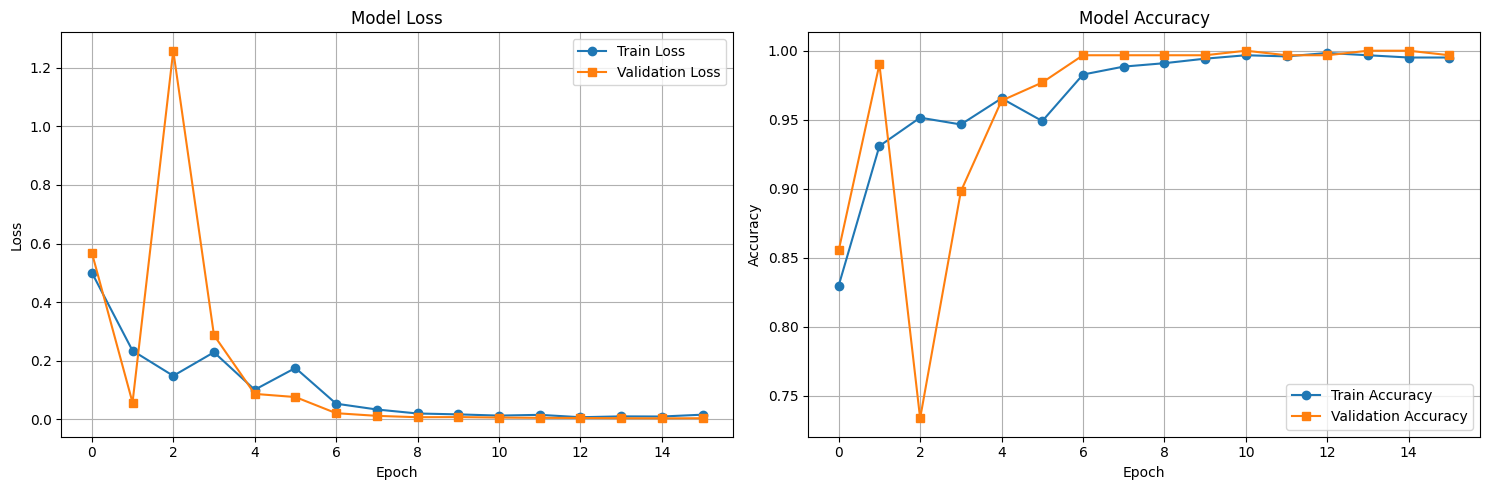

Evaluating on test set...


100%|██████████| 6/6 [00:00<00:00,  8.46it/s]


Test Accuracy: 58.73%
Test Loss: 1.5956

Classification Report:
              precision    recall  f1-score   support

         HGC       0.73      0.64      0.68        74
         LGC       0.50      0.32      0.39        53
         NST       0.63      0.84      0.72        37
         NTL       0.38      0.64      0.48        25

    accuracy                           0.59       189
   macro avg       0.56      0.61      0.57       189
weighted avg       0.60      0.59      0.58       189


Confusion Matrix:
[[47 17 10  0]
 [13 17  3 20]
 [ 0  0 31  6]
 [ 4  0  5 16]]

ROC-AUC Scores:
Macro-average AUC: 0.8357
Micro-average AUC: 0.8288
HGC AUC: 0.8455
LGC AUC: 0.7848
NST AUC: 0.9022
NTL AUC: 0.8105


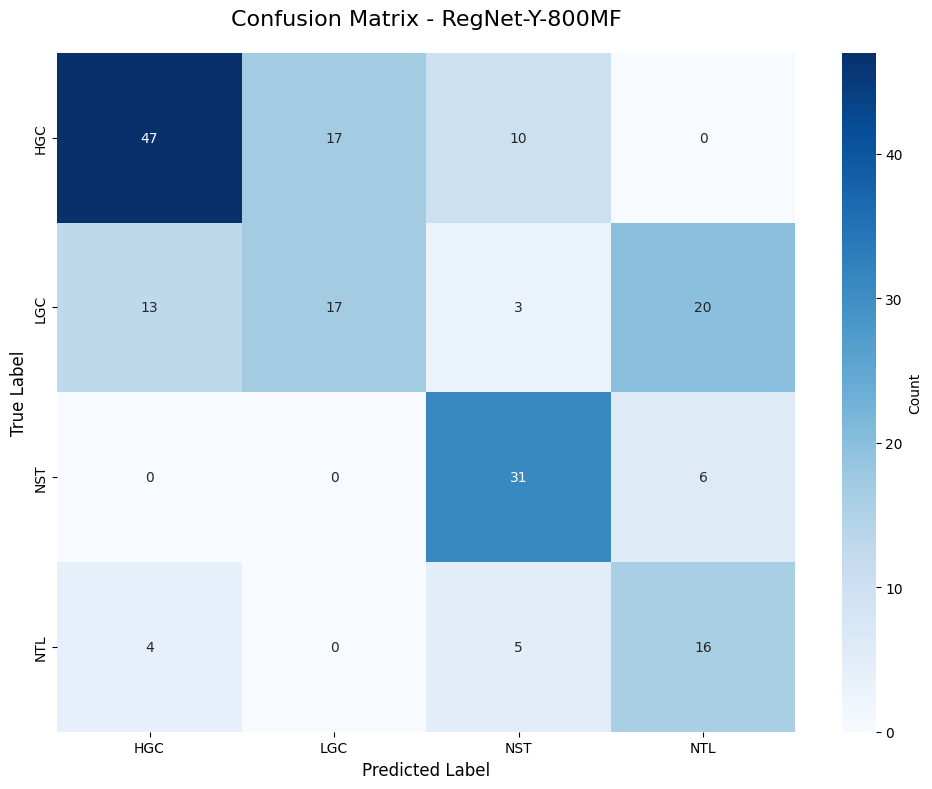

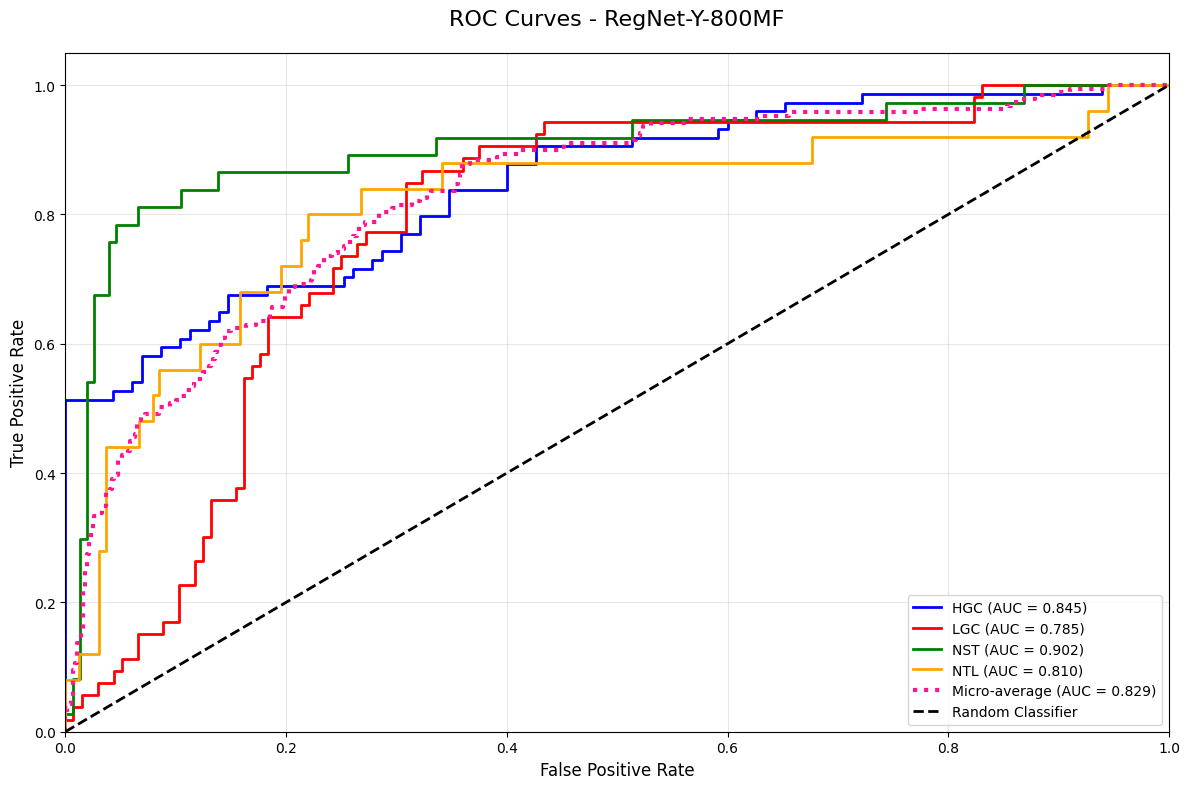


RegNet-Y-800MF training and evaluation complete!


In [17]:
print("=" * 80)
print("Training RegNet-Y-800MF")
print("=" * 80)

# Create RegNet-Y-800MF model
regnet_800mf = create_regnet_y_800mf(
    num_classes=4,
    pretrained=True
)

# Create trainer
trainer_800mf = ModelTrainer(regnet_800mf, train_loader, val_loader, test_loader, device=device)

# Train model
trained_model_800mf = trainer_800mf.train_model(num_epochs=25, lr=0.001, save_best=True, model_name="RegNet-Y-800MF")

# Plot training history
trainer_800mf.plot_training_history(save_path='regnet_y_800mf_training_history.png')

# Evaluate model
results_800mf = trainer_800mf.evaluate_model(class_names=class_names)

# Plot confusion matrix
plot_confusion_matrix(results_800mf['confusion_matrix'], class_names, 'RegNet-Y-800MF',
                      save_path='regnet_y_800mf_confusion_matrix.png')
# Plot ROC curves
roc_auc_800mf = plot_roc_curves(results_800mf['labels'], results_800mf['probabilities'], class_names, 'RegNet-Y-800MF',
                              save_path='regnet_y_800mf_roc_curves.png')
# Store results
results_800mf['model_name'] = 'RegNet-Y-800MF'
results_800mf['roc_auc'] = roc_auc_800mf
all_results.append(results_800mf)

print("\nRegNet-Y-800MF training and evaluation complete!")

## Train RegNet-Y-1.6GF

Training RegNet-Y-1.6GF
Downloading: "https://download.pytorch.org/models/regnet_y_1_6gf-0d7bc02a.pth" to /root/.cache/torch/hub/checkpoints/regnet_y_1_6gf-0d7bc02a.pth


100%|██████████| 43.2M/43.2M [00:00<00:00, 68.3MB/s]


Starting training for 25 epochs...
------------------------------------------------------------
Epoch 1/25
----------


Train : 100%|██████████| 38/38 [00:08<00:00,  4.56it/s, Loss=0.4846, Acc=0.8380]


Train Loss: 0.4846 Acc: 0.8380 Macro-F1: 0.7888


Val : 100%|██████████| 10/10 [00:01<00:00,  9.21it/s, Loss=0.4840, Acc=0.8783]


Val Loss: 0.4840 Acc: 0.8783 Macro-F1: 0.8708
✓ New best model saved with validation macro-F1: 0.8708

Epoch 2/25
----------


Train : 100%|██████████| 38/38 [00:08<00:00,  4.60it/s, Loss=0.3261, Acc=0.8898]


Train Loss: 0.3261 Acc: 0.8898 Macro-F1: 0.8601


Val : 100%|██████████| 10/10 [00:01<00:00,  9.59it/s, Loss=0.2626, Acc=0.9145]


Val Loss: 0.2626 Acc: 0.9145 Macro-F1: 0.8625

Epoch 3/25
----------


Train : 100%|██████████| 38/38 [00:08<00:00,  4.63it/s, Loss=0.2035, Acc=0.9276]


Train Loss: 0.2035 Acc: 0.9276 Macro-F1: 0.9025


Val : 100%|██████████| 10/10 [00:01<00:00,  9.66it/s, Loss=0.1094, Acc=0.9539]


Val Loss: 0.1094 Acc: 0.9539 Macro-F1: 0.9245
✓ New best model saved with validation macro-F1: 0.9245

Epoch 4/25
----------


Train : 100%|██████████| 38/38 [00:08<00:00,  4.61it/s, Loss=0.1283, Acc=0.9556]


Train Loss: 0.1283 Acc: 0.9556 Macro-F1: 0.9488


Val : 100%|██████████| 10/10 [00:01<00:00,  9.48it/s, Loss=0.2047, Acc=0.9375]


Val Loss: 0.2047 Acc: 0.9375 Macro-F1: 0.9116

Epoch 5/25
----------


Train : 100%|██████████| 38/38 [00:08<00:00,  4.63it/s, Loss=0.1020, Acc=0.9679]


Train Loss: 0.1020 Acc: 0.9679 Macro-F1: 0.9573


Val : 100%|██████████| 10/10 [00:01<00:00,  9.55it/s, Loss=0.0479, Acc=0.9803]


Val Loss: 0.0479 Acc: 0.9803 Macro-F1: 0.9791
✓ New best model saved with validation macro-F1: 0.9791

Epoch 6/25
----------


Train : 100%|██████████| 38/38 [00:08<00:00,  4.63it/s, Loss=0.1628, Acc=0.9597]


Train Loss: 0.1628 Acc: 0.9597 Macro-F1: 0.9511


Val : 100%|██████████| 10/10 [00:01<00:00,  9.72it/s, Loss=2.7491, Acc=0.7007]


Val Loss: 2.7491 Acc: 0.7007 Macro-F1: 0.6508

Epoch 7/25
----------


Train : 100%|██████████| 38/38 [00:08<00:00,  4.62it/s, Loss=0.1635, Acc=0.9408]


Train Loss: 0.1635 Acc: 0.9408 Macro-F1: 0.9214


Val : 100%|██████████| 10/10 [00:01<00:00,  8.94it/s, Loss=0.0959, Acc=0.9638]


Val Loss: 0.0959 Acc: 0.9638 Macro-F1: 0.9471

Epoch 8/25
----------


Train : 100%|██████████| 38/38 [00:08<00:00,  4.64it/s, Loss=0.0510, Acc=0.9860]


Train Loss: 0.0510 Acc: 0.9860 Macro-F1: 0.9840


Val : 100%|██████████| 10/10 [00:01<00:00,  9.86it/s, Loss=0.0270, Acc=0.9868]


Val Loss: 0.0270 Acc: 0.9868 Macro-F1: 0.9855
✓ New best model saved with validation macro-F1: 0.9855

Epoch 9/25
----------


Train : 100%|██████████| 38/38 [00:08<00:00,  4.64it/s, Loss=0.0276, Acc=0.9918]


Train Loss: 0.0276 Acc: 0.9918 Macro-F1: 0.9933


Val : 100%|██████████| 10/10 [00:01<00:00,  9.40it/s, Loss=0.0183, Acc=0.9901]


Val Loss: 0.0183 Acc: 0.9901 Macro-F1: 0.9918
✓ New best model saved with validation macro-F1: 0.9918

Epoch 10/25
----------


Train : 100%|██████████| 38/38 [00:08<00:00,  4.60it/s, Loss=0.0203, Acc=0.9918]


Train Loss: 0.0203 Acc: 0.9918 Macro-F1: 0.9923


Val : 100%|██████████| 10/10 [00:01<00:00,  9.56it/s, Loss=0.0139, Acc=0.9967]


Val Loss: 0.0139 Acc: 0.9967 Macro-F1: 0.9971
✓ New best model saved with validation macro-F1: 0.9971

Epoch 11/25
----------


Train : 100%|██████████| 38/38 [00:08<00:00,  4.60it/s, Loss=0.0148, Acc=0.9942]


Train Loss: 0.0148 Acc: 0.9942 Macro-F1: 0.9943


Val : 100%|██████████| 10/10 [00:01<00:00,  8.98it/s, Loss=0.0103, Acc=0.9934]


Val Loss: 0.0103 Acc: 0.9934 Macro-F1: 0.9948

Epoch 12/25
----------


Train : 100%|██████████| 38/38 [00:08<00:00,  4.60it/s, Loss=0.0160, Acc=0.9959]


Train Loss: 0.0160 Acc: 0.9959 Macro-F1: 0.9957


Val : 100%|██████████| 10/10 [00:01<00:00,  9.23it/s, Loss=0.0119, Acc=1.0000]


Val Loss: 0.0119 Acc: 1.0000 Macro-F1: 1.0000
✓ New best model saved with validation macro-F1: 1.0000

Epoch 13/25
----------


Train : 100%|██████████| 38/38 [00:08<00:00,  4.60it/s, Loss=0.0190, Acc=0.9951]


Train Loss: 0.0190 Acc: 0.9951 Macro-F1: 0.9935


Val : 100%|██████████| 10/10 [00:01<00:00,  9.40it/s, Loss=0.0083, Acc=1.0000]


Val Loss: 0.0083 Acc: 1.0000 Macro-F1: 1.0000

Epoch 14/25
----------


Train : 100%|██████████| 38/38 [00:08<00:00,  4.60it/s, Loss=0.0101, Acc=0.9975]


Train Loss: 0.0101 Acc: 0.9975 Macro-F1: 0.9981


Val : 100%|██████████| 10/10 [00:01<00:00,  9.48it/s, Loss=0.0072, Acc=1.0000]


Val Loss: 0.0072 Acc: 1.0000 Macro-F1: 1.0000

Epoch 15/25
----------


Train : 100%|██████████| 38/38 [00:08<00:00,  4.58it/s, Loss=0.0069, Acc=0.9992]


Train Loss: 0.0069 Acc: 0.9992 Macro-F1: 0.9994


Val : 100%|██████████| 10/10 [00:01<00:00,  9.45it/s, Loss=0.0049, Acc=1.0000]


Val Loss: 0.0049 Acc: 1.0000 Macro-F1: 1.0000

Epoch 16/25
----------


Train : 100%|██████████| 38/38 [00:08<00:00,  4.57it/s, Loss=0.0116, Acc=0.9975]


Train Loss: 0.0116 Acc: 0.9975 Macro-F1: 0.9968


Val : 100%|██████████| 10/10 [00:01<00:00,  8.97it/s, Loss=0.0060, Acc=1.0000]


Val Loss: 0.0060 Acc: 1.0000 Macro-F1: 1.0000

Epoch 17/25
----------


Train : 100%|██████████| 38/38 [00:08<00:00,  4.61it/s, Loss=0.0096, Acc=0.9984]


Train Loss: 0.0096 Acc: 0.9984 Macro-F1: 0.9987


Val : 100%|██████████| 10/10 [00:01<00:00,  9.44it/s, Loss=0.0060, Acc=1.0000]


Val Loss: 0.0060 Acc: 1.0000 Macro-F1: 1.0000
Early stopping triggered after 17 epochs
Training complete in 2m 40s
Best validation macro-F1: 1.0000


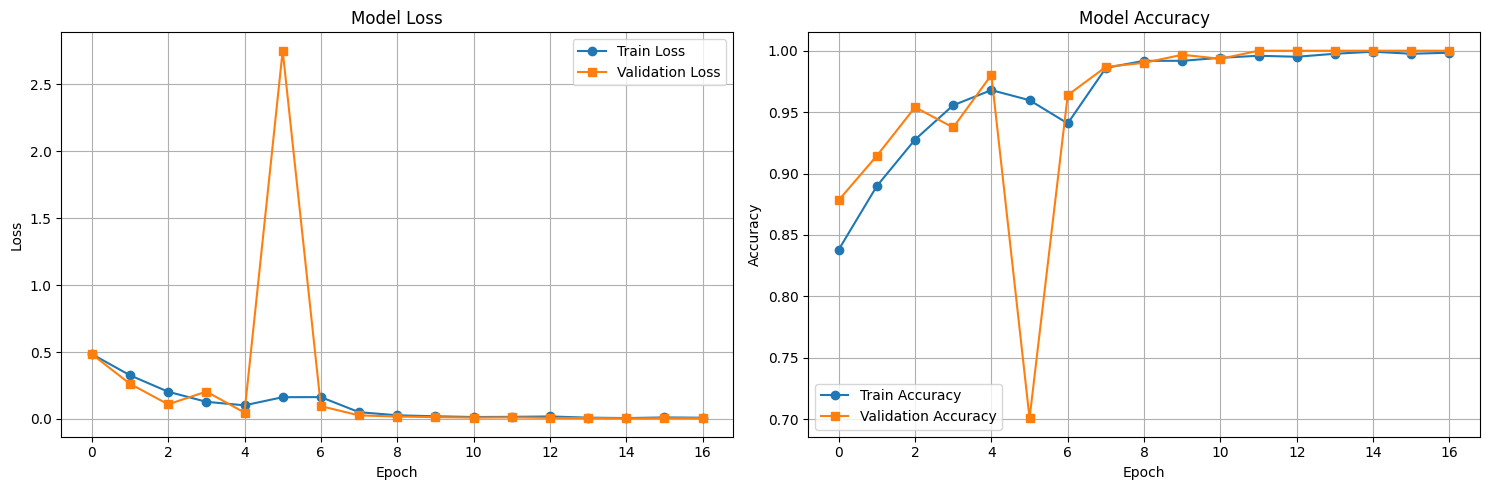

Evaluating on test set...


100%|██████████| 6/6 [00:00<00:00,  7.79it/s]


Test Accuracy: 45.50%
Test Loss: 2.0881

Classification Report:
              precision    recall  f1-score   support

         HGC       0.82      0.38      0.52        74
         LGC       0.38      0.26      0.31        53
         NST       0.78      0.57      0.66        37
         NTL       0.25      0.92      0.40        25

    accuracy                           0.46       189
   macro avg       0.56      0.53      0.47       189
weighted avg       0.61      0.46      0.47       189


Confusion Matrix:
[[28 23  2 21]
 [ 6 14  2 31]
 [ 0  0 21 16]
 [ 0  0  2 23]]

ROC-AUC Scores:
Macro-average AUC: 0.7963
Micro-average AUC: 0.7285
HGC AUC: 0.8321
LGC AUC: 0.5683
NST AUC: 0.8473
NTL AUC: 0.9376


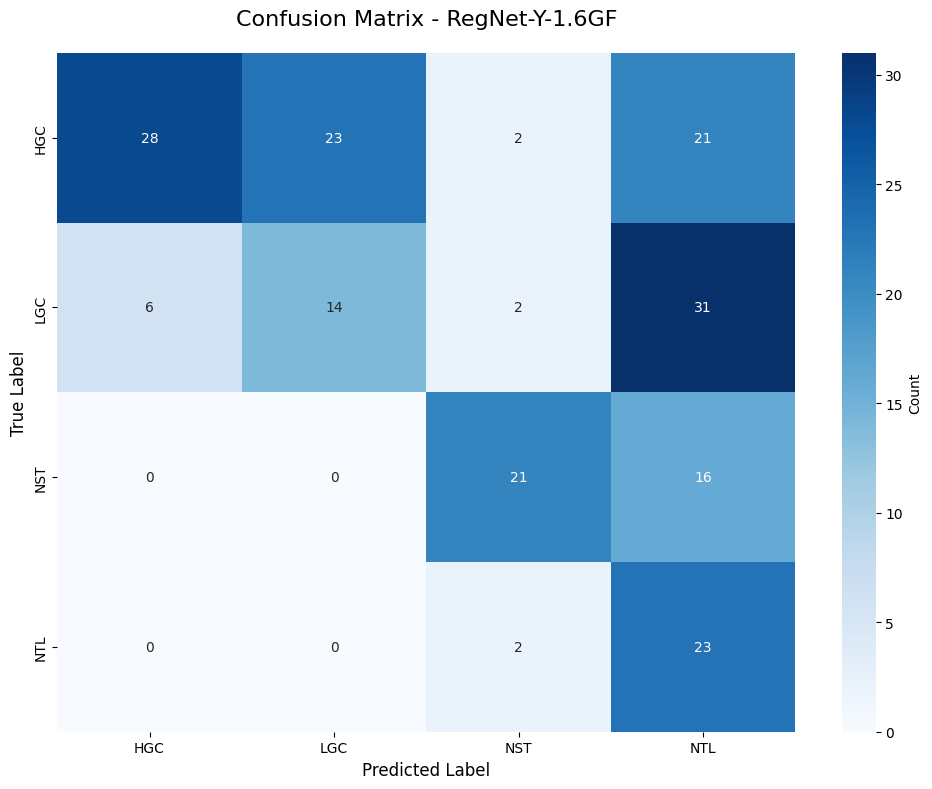

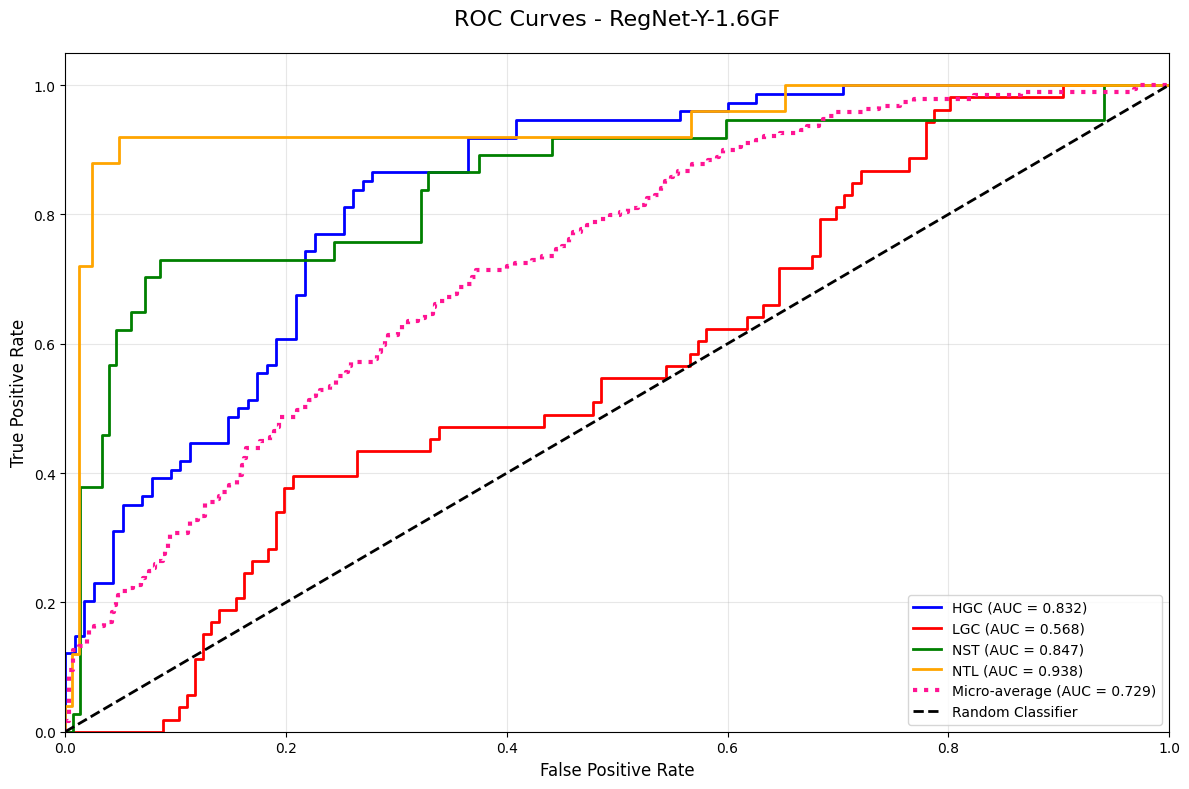


RegNet-Y-1.6GF training and evaluation complete!


In [18]:
print("=" * 80)
print("Training RegNet-Y-1.6GF")
print("=" * 80)

# Create RegNet-Y-1.6GF model
regnet_1_6gf = create_regnet_y_1_6gf(
    num_classes=4,
    pretrained=True
)

# Create trainer
trainer_1_6gf = ModelTrainer(regnet_1_6gf, train_loader, val_loader, test_loader, device=device)

# Train model
trained_model_1_6gf = trainer_1_6gf.train_model(num_epochs=25, lr=0.001, save_best=True, model_name="RegNet-Y-1.6GF")

# Plot training history
trainer_1_6gf.plot_training_history(save_path='regnet_y_1_6gf_training_history.png')

# Evaluate model
results_1_6gf = trainer_1_6gf.evaluate_model(class_names=class_names)

# Plot confusion matrix
plot_confusion_matrix(results_1_6gf['confusion_matrix'], class_names, 'RegNet-Y-1.6GF',
                      save_path='regnet_y_1_6gf_confusion_matrix.png')
# Plot ROC curves
roc_auc_1_6gf = plot_roc_curves(results_1_6gf['labels'], results_1_6gf['probabilities'], class_names, 'RegNet-Y-1.6GF',
                              save_path='regnet_y_1_6gf_roc_curves.png')
# Store results
results_1_6gf['model_name'] = 'RegNet-Y-1.6GF'
results_1_6gf['roc_auc'] = roc_auc_1_6gf
all_results.append(results_1_6gf)

print("\nRegNet-Y-1.6GF training and evaluation complete!")

# Save All Metrics to CSV

In [19]:
# Prepare data for CSV
metrics_data = []

for result in all_results:
    model_name = result['model_name']
    report = result['classification_report']
    
    # Overall metrics
    row = {
        'Model': model_name,
        'Overall_Accuracy': result['accuracy'],
        'Overall_Loss': result['loss'],
        'Macro_Avg_Precision': report['macro avg']['precision'],
        'Macro_Avg_Recall': report['macro avg']['recall'],
        'Macro_Avg_F1': report['macro avg']['f1-score'],
        'Weighted_Avg_Precision': report['weighted avg']['precision'],
        'Weighted_Avg_Recall': report['weighted avg']['recall'],
        'Weighted_Avg_F1': report['weighted avg']['f1-score'],
    }
    
    # Per-class metrics
    for class_name in class_names:
        row[f'{class_name}_Precision'] = report[class_name]['precision']
        row[f'{class_name}_Recall'] = report[class_name]['recall']
        row[f'{class_name}_F1'] = report[class_name]['f1-score']
        row[f'{class_name}_Support'] = report[class_name]['support']
    
    # ROC-AUC scores
    row['Macro_AUC'] = result['macro_auc']
    row['Micro_AUC'] = result['micro_auc']
    for class_name in class_names:
        row[f'{class_name}_AUC'] = result['per_class_auc'][class_name]
    
    # Also store ROC-AUC from plot_roc_curves if available
    if 'roc_auc' in result:
        for i, class_name in enumerate(class_names):
            row[f'{class_name}_Plot_AUC'] = result['roc_auc'][i]
        row['Micro_Avg_Plot_AUC'] = result['roc_auc']['micro']
    
    metrics_data.append(row)

# Create DataFrame
metrics_df = pd.DataFrame(metrics_data)

# Save to CSV
csv_path = 'RegNet_metrics.csv'
metrics_df.to_csv(csv_path, index=False)

print(f"\nMetrics saved to: {csv_path}")
print("\nMetrics Summary:")
print(metrics_df.to_string())



Metrics saved to: RegNet_metrics.csv

Metrics Summary:
            Model  Overall_Accuracy  Overall_Loss  Macro_Avg_Precision  Macro_Avg_Recall  Macro_Avg_F1  Weighted_Avg_Precision  Weighted_Avg_Recall  Weighted_Avg_F1  HGC_Precision  HGC_Recall    HGC_F1  HGC_Support  LGC_Precision  LGC_Recall    LGC_F1  LGC_Support  NST_Precision  NST_Recall   NST_F1  NST_Support  NTL_Precision  NTL_Recall    NTL_F1  NTL_Support  Macro_AUC  Micro_AUC   HGC_AUC   LGC_AUC   NST_AUC   NTL_AUC  HGC_Plot_AUC  LGC_Plot_AUC  NST_Plot_AUC  NTL_Plot_AUC  Micro_Avg_Plot_AUC
0  RegNet-Y-400MF         50.793651      1.579577             0.509532          0.571206      0.517915                0.518739             0.507937         0.495351       0.471698    0.337838  0.393701         74.0       0.578947    0.415094  0.483516         53.0       0.647059    0.891892  0.75000         37.0       0.340426        0.64  0.444444         25.0   0.799479   0.777544  0.670858  0.769700  0.924431  0.832927      0.670858   